In [6]:
# StyleGAN3 Demo for Script-Based Background Generation
import torch
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import PIL.Image
import os
from IPython.display import HTML, display
from base64 import b64encode
import moviepy.editor as mp

# Install requirements
!pip install ninja
!git clone https://github.com/NVlabs/stylegan3
%cd stylegan3
!pip install -r requirements.txt

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 212 (delta 99), reused 90 (delta 90), pack-reused 49 (from 1)
Receiving objects: 100% (212/212), 4.16 MiB | 8.40 MiB/s, done.
Resolving deltas: 100% (108/108), done.
/content/stylegan3/stylegan3
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [7]:
# Download StyleGAN2 landscape model
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl -O landscape.pkl

import legacy
import dnnlib

# Load the network
device = torch.device('cuda')
with dnnlib.util.open_url('landscape.pkl') as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)

--2025-03-13 01:04:56--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 216.137.39.20, 216.137.39.37, 216.137.39.99, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|216.137.39.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624133 (364M) [binary/octet-stream]
Saving to: ‘landscape.pkl’

landscape.pkl       100%[===================>] 363.94M   209MB/s    in 1.7s    

2025-03-13 01:04:59 (209 MB/s) - ‘landscape.pkl’ saved [381624133/381624133]



Extracted scenes:
Scene 1: EXT. FOREST - DAY
Scene 2: INT. ABANDONED WAREHOUSE - NIGHT
Scene 3: EXT. FUTURISTIC CITY - NIGHT
Setting up PyTorch plugin "upfirdn2d_plugin"... 

If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(



Done.


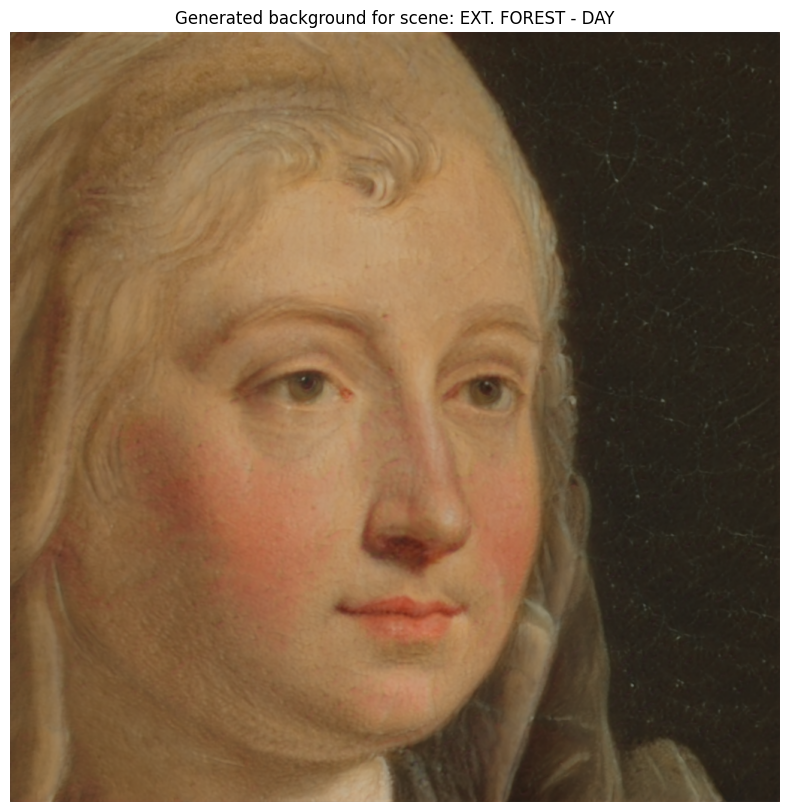

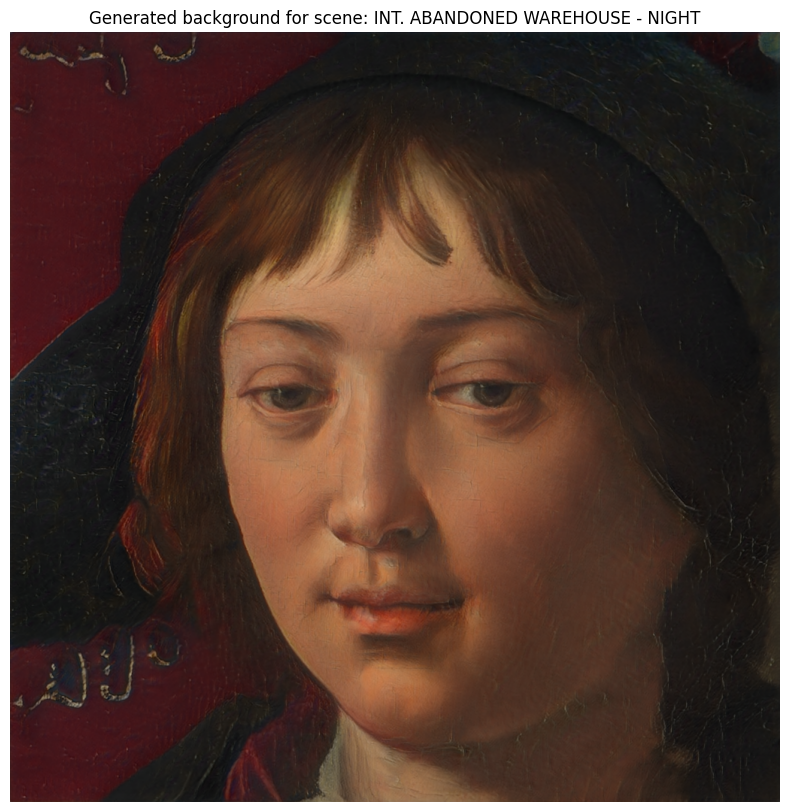

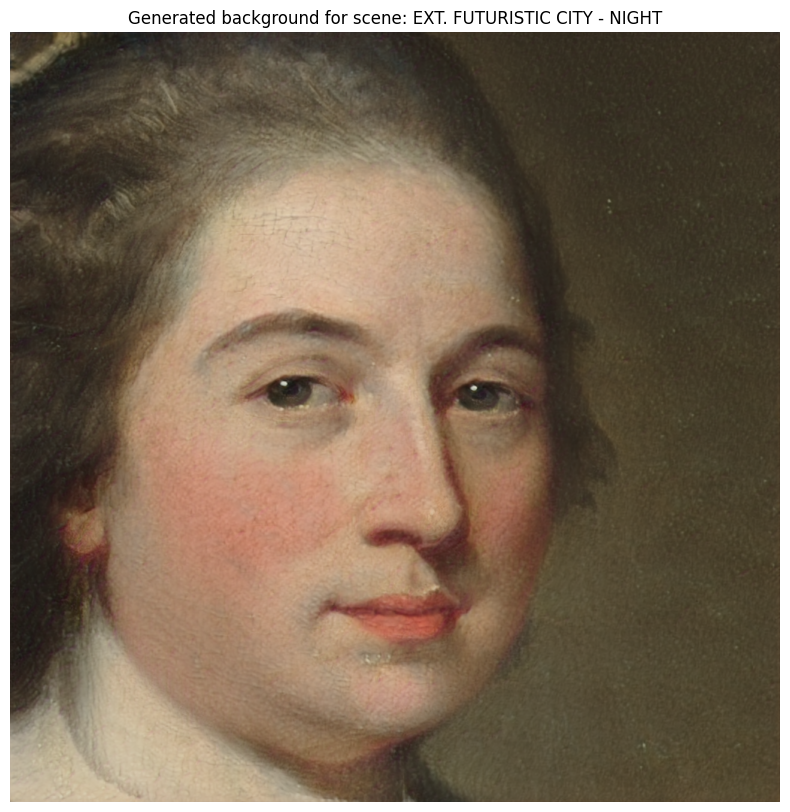

In [8]:
def parse_script_demo(script_text):
    """Simple demonstration of script scene parsing"""
    # Split by double newlines to identify scene breaks (simplified)
    scenes = script_text.split('\n\n')
    scenes = [s.strip() for s in scenes if s.strip()]

    # Extract key descriptive words (simplified)
    scene_keywords = []
    for scene in scenes:
        # Just extract first line as scene description for demo
        description = scene.split('\n')[0].strip()
        scene_keywords.append(description)

    return scene_keywords

# Example script snippet
script_demo = """
EXT. FOREST - DAY
Tall pines sway gently in the afternoon light, casting dappled shadows.

INT. ABANDONED WAREHOUSE - NIGHT
Moonlight streams through broken windows, illuminating dust particles.

EXT. FUTURISTIC CITY - NIGHT
Neon signs reflect in puddles as flying vehicles zip between skyscrapers.
"""

scene_descriptions = parse_script_demo(script_demo)
print("Extracted scenes:")
for i, desc in enumerate(scene_descriptions):
    print(f"Scene {i+1}: {desc}")

def generate_image(G, z, truncation_psi=0.7):
    """Generate image from latent vector"""
    img = G(z, None, truncation_psi=truncation_psi)
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

# Generate random latent vectors for our scenes
seed = 1000  # For reproducibility
torch.manual_seed(seed)
latent_vectors = []
for i in range(len(scene_descriptions)):
    # Generate a random latent vector - in real implementation,
    # these would be mapped from scene text
    z = torch.randn(1, G.z_dim).to(device)
    latent_vectors.append(z)

    # Generate and display image
    img = generate_image(G, z)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.array(img))
    plt.title(f"Generated background for scene: {scene_descriptions[i]}")
    plt.axis('off')
    plt.show()

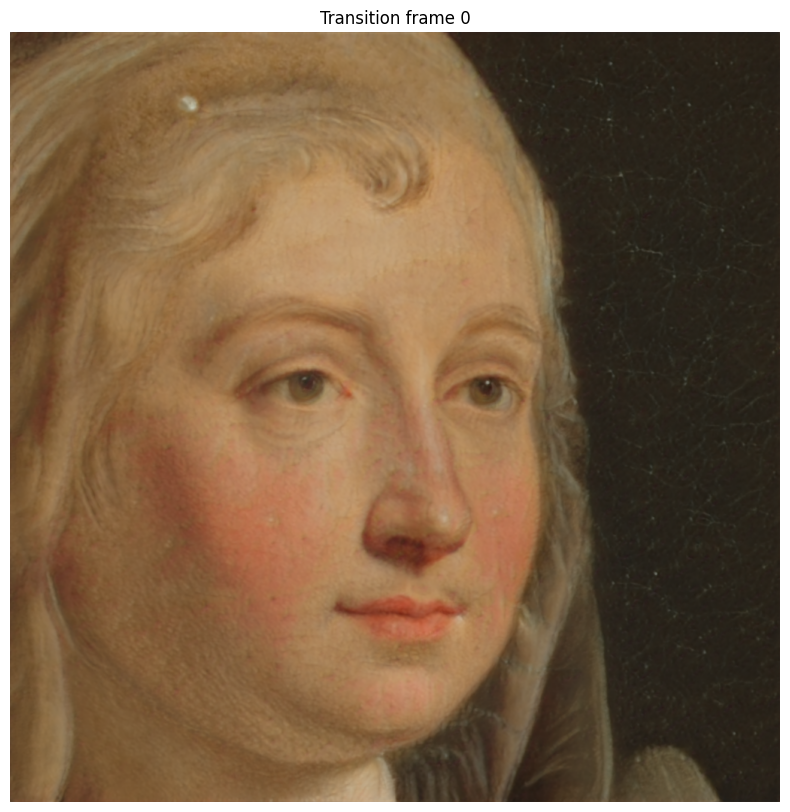

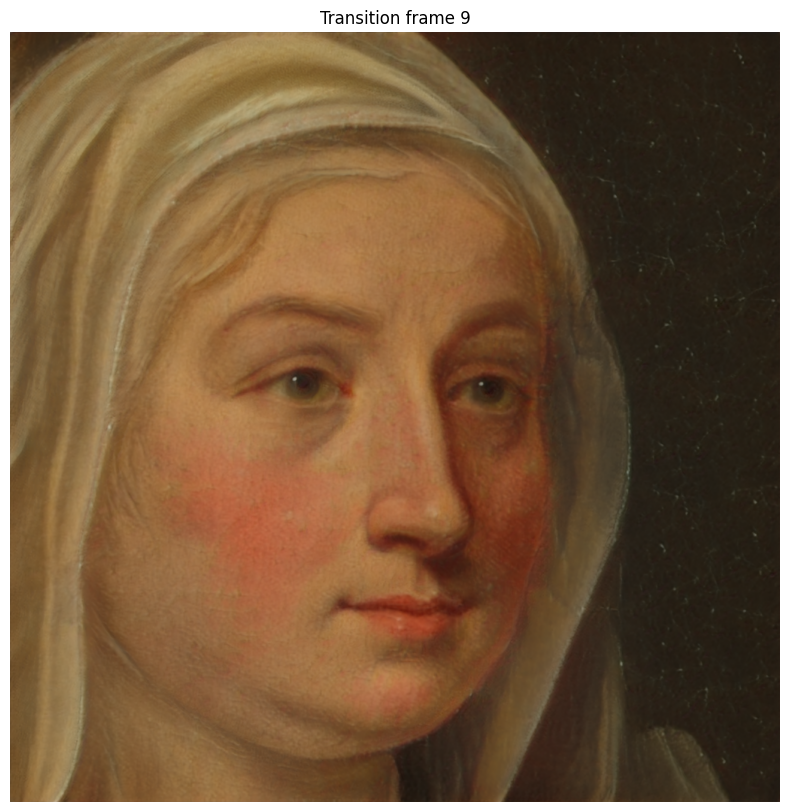

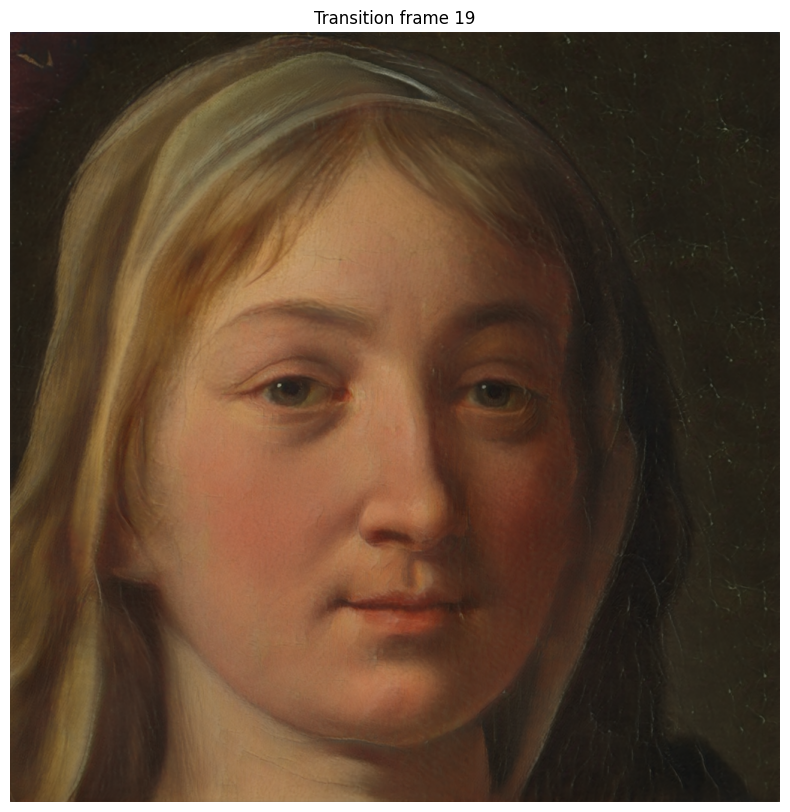

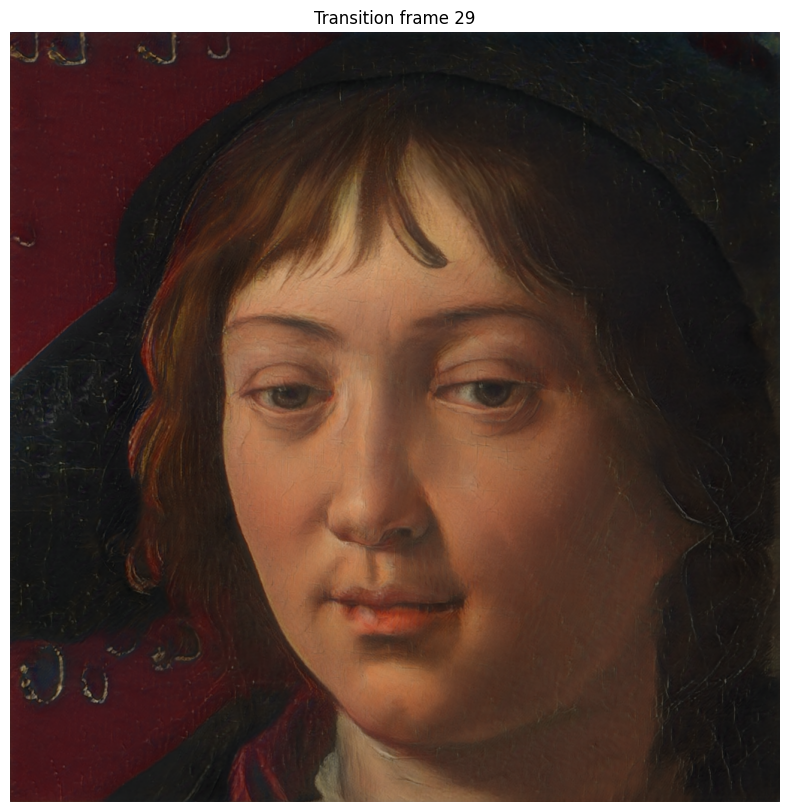

Moviepy - Building video transition_demo.mp4.
Moviepy - Writing video transition_demo.mp4



Moviepy - Done !
Moviepy - video ready transition_demo.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# Create a transition between first two scenes
def create_transition_demo(G, z1, z2, steps=30):
    """Create transition frames between two scenes"""
    frames = []
    for i in range(steps):
        t = i / (steps - 1)
        z_interp = z1 * (1 - t) + z2 * t
        img = generate_image(G, z_interp)
        frames.append(np.array(img))

    return frames

# Generate transition between first two scenes
transition_frames = create_transition_demo(G, latent_vectors[0], latent_vectors[1])

# Display a few frames from the transition
for i in [0, 9, 19, 29]:
    plt.figure(figsize=(10, 10))
    plt.imshow(transition_frames[i])
    plt.title(f"Transition frame {i}")
    plt.axis('off')
    plt.show()

# Create short video of the transition
frames_path = "./frames/"
os.makedirs(frames_path, exist_ok=True)

for i, frame in enumerate(transition_frames):
    PIL.Image.fromarray(frame).save(f"{frames_path}/frame_{i:04d}.png")

# Create video using moviepy
clip = mp.ImageSequenceClip(frames_path, fps=24)
video_path = "transition_demo.mp4"
clip.write_videofile(video_path, codec="libx264")

# Make the video available for download in Colab
files.download(video_path)

# Also display the video in the notebook
def show_video(video_path):
    mp4 = open(video_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f"""
    <video width=600 controls>
        <source src="{data_url}" type="video/mp4">
    </video>
    """)

display(show_video(video_path))